# Medical Q&A Assistant - Prompt Testing

## Setup and Environment Configuration

In [1]:
# Cell 1: Install required packages
!pip install -q transformers torch numpy pandas matplotlib tqdm colorama accelerate bitsandbytes sentencepiece einops ollama requests scikit-learn


In [2]:
# Cell 2: Import necessary libraries
import os
import sys
import json
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from colorama import Fore, Style
import logging
import requests
import gc
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Memory management function
def clear_memory():
    """Clear GPU memory and garbage collect"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    logger.info("Memory cleared")


2025-06-23 20:23:35,312 - INFO - Using device: cpu


## Model Loading

In [6]:
# Cell 3: Load Qwen3-4B Model
def load_model(model_name="Qwen/Qwen3-4B", use_4bit=False):  # Actual Qwen3 4B model
    """
    Load the Qwen3-4B model with optimized settings for CPU environments
    """
    logger.info(f"Loading model: {model_name}")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_name, 
        trust_remote_code=True
    )
    
    # Set padding token if not already set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    
    # Load model with CPU optimizations (remove device_map to avoid conflict)
    model_kwargs = {
        "trust_remote_code": True,
        "torch_dtype": torch.float32,  # Use float32 for CPU
        "low_cpu_mem_usage": True,
    }
    
    try:
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            **model_kwargs
        )
        
        # Move model to CPU explicitly
        model = model.to('cpu')
        
        # Create text generation pipeline (no device parameter since model is already on CPU)
        pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer
        )
        
        logger.info("Qwen3-4B model loaded successfully on CPU!")
        return tokenizer, model, pipe
    
    except Exception as e:
        logger.error(f"Error loading model: {str(e)}")
        # Fallback to base model if chat model fails
        if "Qwen3-4B" in model_name and "Base" not in model_name:
            logger.info("Trying base model as fallback...")
            return load_model("Qwen/Qwen3-4B-Base", use_4bit=False)
        raise

# Load model with memory monitoring
import psutil

def log_memory_usage():
    """Log current memory usage"""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    logger.info(f"Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# Log initial memory usage
log_memory_usage()

# Load the actual Qwen3-4B model
tokenizer, model, pipe = load_model(use_4bit=False)

# Log memory usage after model loading
log_memory_usage()

2025-06-23 20:28:17,805 - INFO - Memory usage: 64623.46 MB
2025-06-23 20:28:17,806 - INFO - Loading model: Qwen/Qwen3-4B


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cpu
2025-06-23 20:28:19,186 - INFO - Qwen3-4B model loaded successfully on CPU!
2025-06-23 20:28:19,186 - INFO - Memory usage: 80029.48 MB


## Prompt Templates Implementation

In [7]:
# Cell 4: Define prompt templates
# Zero-shot prompt template
zero_shot_template = """As a medical information assistant, please answer the following healthcare question with accurate information. If you're uncertain, clearly state the limitations of your knowledge.

IMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only and is not a substitute for professional medical advice. Always consult with a qualified healthcare provider for medical concerns.

Question: {{QUERY}}"""

# Few-shot prompt template
few_shot_template = """As a medical information assistant, here are some examples of how to answer healthcare questions:

Question: What are the symptoms of strep throat?
Answer: Strep throat typically presents with sudden sore throat, pain when swallowing, fever over 101°F, red and swollen tonsils (sometimes with white patches), tiny red spots on the roof of the mouth, and swollen lymph nodes in the neck. Unlike viral infections, strep throat usually doesn't cause cough, runny nose, or hoarseness. 

IMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only. A healthcare professional should confirm diagnosis through testing, as many conditions can cause similar symptoms.

Question: How does insulin work in the body?
Answer: Insulin is a hormone produced by beta cells in the pancreas that regulates blood glucose levels. When you consume carbohydrates, they break down into glucose in the bloodstream. The pancreas then releases insulin, which acts like a key that allows glucose to enter cells for energy use. In people with diabetes, either insufficient insulin is produced (Type 1) or cells become resistant to insulin's effects (Type 2), resulting in elevated blood glucose levels.

IMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only and not a substitute for professional medical advice. If you have concerns about diabetes or insulin function, please consult with a healthcare provider.

Question: What is the difference between Alzheimer's and dementia?
Answer: Dementia is a general term for symptoms affecting memory, thinking, and social abilities severely enough to interfere with daily functioning. Alzheimer's disease is the most common specific cause of dementia, accounting for 60-80% of cases. While Alzheimer's is characterized by specific brain changes (amyloid plaques and tau tangles), dementia can be caused by various conditions including vascular issues, Lewy body disease, and others. All Alzheimer's patients have dementia, but not all dementia patients have Alzheimer's.

IMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only. If you're concerned about cognitive changes in yourself or a loved one, please consult with a healthcare professional for proper evaluation and support.

Now please answer this medical question:
{{QUERY}}"""

# Chain-of-thought prompt template
cot_template = """As a medical information assistant, please answer the following healthcare question. Think through your reasoning step by step before providing your final answer.

Question: {{QUERY}}

Let me reason through this systematically:
1) First, I'll consider what medical concepts are involved in this question
2) Then, I'll analyze relevant mechanisms, causes, or processes
3) Next, I'll evaluate important distinctions or differential considerations
4) Finally, I'll formulate a clear, accurate answer based on established medical knowledge

Reasoning:"""

# Meta-prompt template
meta_template = """As a medical information assistant, I'll answer the following healthcare question by breaking it down into sub-questions I need to answer first.

Main Question: {{QUERY}}

Let me ask myself some clarifying questions:
1) What specific medical concepts do I need to understand to answer this question?
2) What are the key mechanisms or processes involved?
3) Are there any important distinctions or considerations I should address?
4) What limitations exist in my knowledge about this topic?
5) What safety warnings or medical disclaimers should I include?

Now I'll answer each of these sub-questions to build my complete response:"""

# Save templates to files
os.makedirs("prompts", exist_ok=True)

with open("prompts/zero_shot.txt", "w") as f:
    f.write(zero_shot_template)

with open("prompts/few_shot.txt", "w") as f:
    f.write(few_shot_template)

with open("prompts/cot_prompt.txt", "w") as f:
    f.write(cot_template)

with open("prompts/meta_prompt.txt", "w") as f:
    f.write(meta_template)

# Define prompt functions
def zero_shot_prompt(query):
    return zero_shot_template.replace("{{QUERY}}", query)

def few_shot_prompt(query):
    return few_shot_template.replace("{{QUERY}}", query)

def cot_prompt(query):
    return cot_template.replace("{{QUERY}}", query)

def meta_prompt(query):
    return meta_template.replace("{{QUERY}}", query)

# Define prompt types dictionary
prompt_types = {
    "zero_shot": zero_shot_prompt,
    "few_shot": few_shot_prompt,
    "cot": cot_prompt,
    "meta": meta_prompt
}

logger.info("Prompt templates created and saved!")


2025-06-23 20:28:24,921 - INFO - Prompt templates created and saved!


## Medical Safety Functions

In [8]:
# Cell 5: Medical safety functions
def add_medical_disclaimer(response):
    """Add medical disclaimer if not already present"""
    disclaimer = "\n\nIMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only and is not a substitute for professional medical advice. Always consult with a qualified healthcare provider for medical concerns."
    
    if "DISCLAIMER" not in response and "disclaimer" not in response.lower():
        return response + disclaimer
    return response

def check_emergency_symptoms(query, response):
    """Check for emergency symptoms that require immediate attention"""
    emergency_symptoms = [
        "chest pain", "severe bleeding", "difficulty breathing", "shortness of breath",
        "sudden numbness", "sudden weakness", "sudden confusion", "sudden severe headache",
        "sudden vision loss", "suicidal", "suicide", "heart attack", "stroke"
    ]
    
    emergency_warning = "\n\n⚠️ EMERGENCY WARNING: The symptoms described may indicate a serious medical condition requiring immediate attention. Please seek emergency medical care immediately by calling emergency services or going to the nearest emergency room."
    
    # Check if any emergency symptoms are mentioned in the query
    if any(symptom in query.lower() for symptom in emergency_symptoms):
        if "EMERGENCY WARNING" not in response and "emergency" not in response.lower():
            return response + emergency_warning
    
    return response

def ensure_response_safety(query, response):
    """Ensure response includes proper medical safety elements"""
    # Add medical disclaimer
    response = add_medical_disclaimer(response)
    
    # Check for emergency symptoms
    response = check_emergency_symptoms(query, response)
    
    # Avoid diagnostic language
    response = avoid_diagnostic_language(response)
    
    return response

def avoid_diagnostic_language(response):
    """Replace diagnostic language with more appropriate phrasing"""
    diagnostic_patterns = [
        (r"you have ([a-zA-Z\s]+)", r"you may be experiencing symptoms consistent with \1"),
        (r"you are suffering from ([a-zA-Z\s]+)", r"you may be experiencing \1"),
        (r"you definitely have ([a-zA-Z\s]+)", r"your symptoms may be consistent with \1"),
        (r"you should take ([a-zA-Z0-9\s]+)", r"some healthcare providers may recommend \1, but consult your doctor"),
        (r"I diagnose you with ([a-zA-Z\s]+)", r"these symptoms are sometimes associated with \1")
    ]
    
    for pattern, replacement in diagnostic_patterns:
        response = re.sub(pattern, replacement, response, flags=re.IGNORECASE)
    
    return response


## Hallucination Detection

In [9]:
# Cell 6: Hallucination detection
def detect_hallucinations(response, query, expected_concepts=None):
    """
    Detect potential hallucinations in model responses
    Returns a hallucination score and flagged issues
    """
    hallucination_indicators = {
        "definitive_claims": [
            r"100% effective", r"always works", r"cures all", r"completely safe",
            r"guaranteed to", r"never causes", r"all patients", r"everyone with"
        ],
        "specific_numbers": [
            r"\d{2,3}% of (patients|people|cases)", r"studies show \d{2,3}%"
        ],
        "unverifiable_claims": [
            r"recent studies show", r"doctors agree that", r"research has proven",
            r"it is well established", r"it is widely accepted"
        ],
        "medical_advice": [
            r"you should", r"you must", r"you need to", r"I recommend",
            r"take \d+ (mg|milligrams)", r"increase your dosage", r"reduce your dosage"
        ]
    }
    
    issues = []
    hallucination_score = 0
    
    # Check for definitive claims
    for pattern in hallucination_indicators["definitive_claims"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Definitive claim detected: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 2
    
    # Check for specific unverifiable numbers
    for pattern in hallucination_indicators["specific_numbers"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Specific unverifiable statistic: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 1.5
    
    # Check for unverifiable claims
    for pattern in hallucination_indicators["unverifiable_claims"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Unverifiable claim: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 1
    
    # Check for medical advice
    for pattern in hallucination_indicators["medical_advice"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Medical advice detected: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 2
    
    # Check for expected concepts (if provided)
    if expected_concepts:
        found_concepts = 0
        for concept in expected_concepts:
            if concept.lower() in response.lower():
                found_concepts += 1
        
        concept_coverage = found_concepts / len(expected_concepts)
        if concept_coverage < 0.5:
            issues.append(f"Low coverage of expected medical concepts: {found_concepts}/{len(expected_concepts)}")
            hallucination_score += 1
    
    # Normalize score between 0-5 (for evaluation criteria)
    normalized_score = min(5, hallucination_score / 2)
    
    return {
        "score": normalized_score,
        "issues": issues,
        "severity": "High" if normalized_score > 3.5 else "Medium" if normalized_score > 2 else "Low"
    }


## Response Generation and Testing

In [10]:
# Cell 7: Generate and test responses
def generate_medical_response(query, prompt_type="cot"):
    """Generate a medical response using the specified prompt type"""
    try:
        # Get the appropriate prompt function
        prompt_func = prompt_types.get(prompt_type, cot_prompt)
        
        # Format the prompt
        prompt = prompt_func(query)
        
        # Generate response
        logger.info(f"Generating response using {prompt_type} prompt")
        result = pipe(prompt, return_full_text=False)[0]["generated_text"]
        
        # Ensure response safety
        safe_response = ensure_response_safety(query, result)
        
        return {
            "query": query,
            "prompt_type": prompt_type,
            "prompt": prompt,
            "raw_response": result,
            "safe_response": safe_response,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    
    except Exception as e:
        logger.error(f"Error generating response: {str(e)}")
        return {
            "query": query,
            "prompt_type": prompt_type,
            "error": str(e),
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

# Test queries from the project specification
test_queries = [
    {
        "id": 1,
        "query": "What are the early symptoms of diabetes?",
        "category": "Symptom Explanation",
        "expected_concepts": ["polyuria", "polydipsia", "weight loss", "fatigue", "blurred vision"]
    },
    {
        "id": 2,
        "query": "Explain what hypertension means in simple terms",
        "category": "Medical Term Simplification",
        "expected_concepts": ["high blood pressure", "heart", "blood vessels", "systolic", "diastolic"]
    },
    {
        "id": 3,
        "query": "Should I be worried about chest pain?",
        "category": "General Health Guidance",
        "expected_concepts": ["emergency", "heart attack", "seek medical attention", "warning signs"]
    },
    {
        "id": 4,
        "query": "What causes frequent headaches?",
        "category": "Symptom Explanation",
        "expected_concepts": ["stress", "dehydration", "eyestrain", "migraine", "tension"]
    },
    {
        "id": 5,
        "query": "When should someone see a cardiologist?",
        "category": "General Health Guidance",
        "expected_concepts": ["heart disease", "symptoms", "risk factors", "referral", "specialist"]
    }
]

# Save test queries to file
os.makedirs("evaluation", exist_ok=True)
with open("evaluation/input_queries.json", "w") as f:
    json.dump(test_queries, f, indent=2)


## Systematic Testing of All Prompt Types

In [11]:
# Cell 8: Test all prompt types with all queries
def format_response_for_display(response_data):
    """Format a response for display in the notebook"""
    output = f"Query: {response_data['query']}\n\n"
    output += f"Prompt Type: {response_data['prompt_type']}\n\n"
    output += f"Response:\n{response_data['safe_response']}\n\n"
    
    # Add hallucination check
    hallucination_check = detect_hallucinations(
        response_data['safe_response'], 
        response_data['query'],
        next((q['expected_concepts'] for q in test_queries if q['query'] == response_data['query']), None)
    )
    
    output += f"Hallucination Score: {hallucination_check['score']}/5 ({hallucination_check['severity']})\n"
    if hallucination_check['issues']:
        output += "Issues detected:\n"
        for issue in hallucination_check['issues']:
            output += f"- {issue}\n"
    
    return output

# Create results storage
results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "Qwen/Qwen1.5-4B-Chat",
    "responses": []
}

# Process each test query with each prompt type
print("Running tests on all queries with all prompt types...")

for query_data in tqdm(test_queries):
    query = query_data["query"]
    query_id = query_data["id"]
    expected_concepts = query_data.get("expected_concepts", [])
    
    query_results = {
        "query_id": query_id,
        "query": query,
        "category": query_data["category"],
        "responses": {}
    }
    
    for prompt_name, prompt_func in prompt_types.items():
        print(f"\nProcessing query {query_id} with {prompt_name} prompt...")
        
        # Generate response
        response_data = generate_medical_response(query, prompt_name)
        
        # Check for hallucinations
        hallucination_check = detect_hallucinations(
            response_data['safe_response'], 
            query, 
            expected_concepts
        )
        
        # Store results
        query_results["responses"][prompt_name] = {
            "prompt": response_data["prompt"],
            "response": response_data["safe_response"],
            "hallucination_score": hallucination_check["score"],
            "hallucination_issues": hallucination_check["issues"],
            "hallucination_severity": hallucination_check["severity"]
        }
        
        # Display formatted response
        print(format_response_for_display(response_data))
        
        # Clear memory between queries
        clear_memory()
    
    results["responses"].append(query_results)

# Save results to file
with open("evaluation/output_logs.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\nCompleted testing {len(test_queries)} queries with {len(prompt_types)} prompt types")
print(f"Results saved to evaluation/output_logs.json")


Running tests on all queries with all prompt types...


  0%|          | 0/5 [00:00<?, ?it/s]

2025-06-23 20:28:46,697 - INFO - Generating response using zero_shot prompt



Processing query 1 with zero_shot prompt...
Query: What are the early symptoms of diabetes?

Prompt Type: zero_shot

Response:
 

Answer:

Early symptoms of diabetes can vary depending on whether the individual has type 1, type 2, or gestational diabetes. However, common early symptoms may include:

1. Increased thirst (polydipsia): A persistent feeling of thirst that is not satisfied by normal fluid intake.
2. Frequent urination (polyuria): Urinating more frequently than usual, especially at night.
3. Unexplained weight loss: Losing weight without trying, particularly in type 1 diabetes.
4. Fatigue: Feeling unusually tired or weak, even after adequate rest.
5. Blurred vision: Difficulty focusing or seeing clearly.
6. Slow-healing sores or infections: Sores that take longer than usual to heal or infections that are more severe than normal.
7. Tingling or numbness in the hands or feet (neuropathy): A sensation of tingling, numbness, or pain in the extremities.
8. Hunger: Increased appe

2025-06-23 20:29:29,727 - INFO - Memory cleared
2025-06-23 20:29:29,727 - INFO - Generating response using few_shot prompt



Processing query 1 with few_shot prompt...


2025-06-23 20:30:16,022 - INFO - Memory cleared
2025-06-23 20:30:16,022 - INFO - Generating response using cot prompt


Query: What are the early symptoms of diabetes?

Prompt Type: few_shot

Response:
 

Answer: Early symptoms of diabetes can include frequent urination, increased thirst, increased hunger, unexplained weight loss, fatigue, blurred vision, and slow-healing sores. However, some people with diabetes may not experience noticeable symptoms for years. 

IMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only. A healthcare professional should confirm diagnosis through testing, as these symptoms can also be caused by other conditions.
Answer: Early symptoms of diabetes can include frequent urination, increased thirst, increased hunger, unexplained weight loss, fatigue, blurred vision, and slow-healing sores. However, some people with diabetes may not experience noticeable symptoms for years. 

IMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only. A healthcare professional should confirm diagnosis through testing, as these symptoms can also be c

2025-06-23 20:30:58,336 - INFO - Memory cleared
2025-06-23 20:30:58,336 - INFO - Generating response using meta prompt


Query: What are the early symptoms of diabetes?

Prompt Type: cot

Response:
 

Diabetes is a chronic condition characterized by high blood sugar levels. There are two main types: Type 1 and Type 2. The early symptoms of diabetes can vary depending on the type and individual factors.

For Type 1 diabetes, which is an autoimmune condition where the body's immune system attacks insulin-producing cells, the symptoms often develop rapidly. Common early signs include frequent urination (polyuria), increased thirst (polydipsia), unexplained weight loss, and fatigue.

Type 2 diabetes, which is more common and often related to lifestyle factors, may have more subtle symptoms that develop gradually. Early symptoms can include increased hunger (polyphagia), fatigue, blurred vision, slow-healing sores or frequent infections, and tingling or numbness in the hands or feet.

It's important to note that some people with diabetes may not experience明显 symptoms for a long time, which is why regular chec

2025-06-23 20:31:40,839 - INFO - Memory cleared
2025-06-23 20:31:40,840 - INFO - Generating response using zero_shot prompt


Query: What are the early symptoms of diabetes?

Prompt Type: meta

Response:
 

1) The key concepts include the definition of diabetes, the differences between type 1 and type 2 diabetes, and the early signs and symptoms that may indicate the presence of diabetes. I also need to understand how the body regulates blood sugar and the role of insulin in this process.

2) The body regulates blood sugar through a complex system involving the pancreas, which produces insulin to help move glucose from the blood into the cells. In diabetes, this system is impaired, either because the pancreas doesn't produce enough insulin (type 1 or type 2) or because the body's cells don't respond properly to insulin (type 2). This leads to high blood sugar levels, which can cause various symptoms.

3) It's important to distinguish between the early symptoms of type 1 and type 2 diabetes. Type 1 diabetes often presents with more sudden and severe symptoms, while type 2 may develop more gradually. Additional

2025-06-23 20:32:22,699 - INFO - Memory cleared
2025-06-23 20:32:22,699 - INFO - Generating response using few_shot prompt


Query: Explain what hypertension means in simple terms

Prompt Type: zero_shot

Response:
.

Hypertension, also known as high blood pressure, is a condition in which the force of blood against the walls of the arteries is consistently too high. This can lead to serious health problems, such as heart disease, stroke, and kidney damage. It is usually diagnosed when blood pressure readings are consistently above 130/80 mmHg. Blood pressure is measured in millimeters of mercury (mmHg), with the first number representing the systolic pressure (when the heart beats and pushes blood out) and the second number representing the diastolic pressure (when the heart is at rest between beats).

The causes of hypertension can be genetic or lifestyle-related, such as a high-sodium diet, lack of physical activity, obesity, excessive alcohol consumption, and stress. Treatment typically involves lifestyle changes, such as eating a balanced diet, exercising regularly, maintaining a healthy weight, limitin

2025-06-23 20:33:08,561 - INFO - Memory cleared
2025-06-23 20:33:08,561 - INFO - Generating response using cot prompt


Query: Explain what hypertension means in simple terms

Prompt Type: few_shot

Response:
.
Answer:
Hypertension, or high blood pressure, is a condition where the force of blood against the walls of the arteries is consistently too high. This can strain the heart and blood vessels over time, increasing the risk of serious health problems like heart attacks, strokes, and kidney disease. It's usually measured using a sphygmomanometer, with readings expressed as two numbers: systolic (top number) and diastolic (bottom number). A normal blood pressure is less than 120/80 mmHg, while hypertension is generally defined as 130/80 mmHg or higher. However, the exact thresholds can vary based on individual factors and guidelines from healthcare organizations.

IMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only. If you may be experiencing symptoms consistent with concerns about your blood pressure or cardiovascular health, please consult with a healthcare provider for p

2025-06-23 20:33:50,897 - INFO - Memory cleared
2025-06-23 20:33:50,898 - INFO - Generating response using meta prompt


Query: Explain what hypertension means in simple terms

Prompt Type: cot

Response:
 Hypertension is a condition characterized by persistently elevated blood pressure. Blood pressure is the force exerted by blood against the walls of arteries. Normal blood pressure is typically around 120/80 mmHg, with the first number representing systolic pressure (during heartbeats) and the second diastolic (between heartbeats). When this pressure consistently exceeds 130/80 mmHg, it's classified as hypertension. It can lead to serious health issues like heart disease, stroke, and kidney damage. Causes may include genetic factors, lifestyle choices (diet, exercise, alcohol), and other medical conditions. It's often called the "silent killer" because symptoms may be absent until complications arise. Management typically involves lifestyle changes and medications.
Now, to answer the question in simple terms, I need to explain this in layman's language without medical jargon.

Final answer: Hypertensio

2025-06-23 20:34:33,440 - INFO - Memory cleared
2025-06-23 20:34:33,441 - INFO - Generating response using zero_shot prompt


Query: Explain what hypertension means in simple terms

Prompt Type: meta

Response:
 

1) To explain hypertension, I need to understand the definition of blood pressure, the normal range, and what happens when it's too high. I should also know the potential health risks associated with hypertension.

2) Hypertension occurs when the force of blood against the walls of the arteries is consistently too high. This can damage the arteries and strain the heart. The body may compensate by narrowing the arteries, which can lead to further complications.

3) It's important to distinguish between primary (essential) hypertension and secondary hypertension. Primary is more common and has no known cause, while secondary hypertension is caused by other conditions like kidney disease or hormonal disorders.

4) My knowledge is general and based on standard medical information. I should not provide specific medical advice, as this could be misleading. I should also note that diagnosis requires profes

2025-06-23 20:35:15,308 - INFO - Memory cleared
2025-06-23 20:35:15,309 - INFO - Generating response using few_shot prompt


Query: Should I be worried about chest pain?

Prompt Type: zero_shot

Response:
 

I need to provide a comprehensive answer that includes the possible causes of chest pain, when to seek immediate medical attention, and when to consult a doctor. Also, mention the importance of not self-diagnosing and the need for professional evaluation. The answer should be in a clear, easy-to-understand language, and avoid any technical jargon. Additionally, if there are any new developments in the understanding of chest pain, I should mention that. Also, mention the difference between cardiac and non-cardiac causes of chest pain. Also, if there are any new guidelines or recommendations from medical organizations, include those. 

Please make sure that the answer is accurate, up to date, and clearly structured.
Answer:

Chest pain is a serious symptom that can have many possible causes, some of which require immediate medical attention. It’s important to understand the different reasons behind chest p

2025-06-23 20:36:01,289 - INFO - Memory cleared
2025-06-23 20:36:01,289 - INFO - Generating response using cot prompt


Query: Should I be worried about chest pain?

Prompt Type: few_shot

Response:
 
Answer:
Chest pain can have many possible causes, ranging from benign to life-threatening. It is important to consider the nature, location, and associated symptoms of the pain. Common non-emergency causes include heartburn, muscle strain, costochondritis, or anxiety. However, chest pain can also be a sign of serious conditions such as myocardial infarction (heart attack), unstable angina, or pulmonary embolism. 

Key warning signs that require immediate medical attention include: 
- Pain that is persistent, severe, or worsening 
- Pain that radiates to the jaw, neck, back, arm, or shoulder 
- Shortness of breath, nausea, or cold sweat 
- Pain that is not relieved by rest or medication 
- History of heart disease, high blood pressure, or smoking 

If you are experiencing chest pain, it is important to seek medical attention promptly. The severity and characteristics of the pain can help determine the appro

2025-06-23 20:36:44,008 - INFO - Memory cleared
2025-06-23 20:36:44,008 - INFO - Generating response using meta prompt


Query: Should I be worried about chest pain?

Prompt Type: cot

Response:
 Chest pain is a common symptom that can be caused by a variety of conditions, ranging from benign to life-threatening. It's important to determine the nature of the pain, its location, radiation, associated symptoms, and duration to assess the potential severity. The most concerning cause is a heart attack, but other possibilities include gastrointestinal issues, musculoskeletal pain, anxiety, or pulmonary conditions. The key is to recognize warning signs such as persistent, crushing, or radiating pain, shortness of breath, diaphoresis, or pain that worsens with exertion. If the person has risk factors for heart disease or has experienced similar symptoms before, this increases the likelihood of a cardiac cause. However, it's also important to consider non-cardiac causes, especially if the pain is described as sharp, localized, or related to eating. In any case, if the person is experiencing chest pain, they sho

2025-06-23 20:37:26,493 - INFO - Memory cleared
2025-06-23 20:37:26,494 - INFO - Generating response using zero_shot prompt


Query: Should I be worried about chest pain?

Prompt Type: meta

Response:
 

1) To answer the question, I need to understand the following concepts:
- The different possible causes of chest pain
- The importance of recognizing symptoms that may indicate a medical emergency
- The difference between benign and serious chest pain
- The appropriate actions to take in different scenarios

2) The key mechanisms involved include:
- Cardiac mechanisms (e.g., myocardial infarction, angina)
- Non-cardiac mechanisms (e.g., gastroesophageal reflux disease, costochondritis)
- Psychosomatic factors (e.g., anxiety, panic attacks)
- Other systemic conditions (e.g., pulmonary embolism, pericarditis)

3) Important distinctions to address:
- The difference between stable and unstable angina
- The difference between typical and atypical chest pain presentations
- The importance of associated symptoms (e.g., shortness of breath, sweating, radiation of pain)
- The difference between chest pain caused by th

2025-06-23 20:38:08,273 - INFO - Memory cleared
2025-06-23 20:38:08,274 - INFO - Generating response using few_shot prompt


Query: What causes frequent headaches?

Prompt Type: zero_shot

Response:
 What are the possible treatments?
Answer:
Frequent headaches, also known as chronic headaches, can be caused by a variety of factors, including but not limited to:

1. **Tension-type headaches**: These are the most common type of headache, often caused by stress, poor posture, or muscle tension in the neck and scalp.

2. **Migraine headaches**: These are typically characterized by severe, throbbing pain, often on one side of the head, and can be accompanied by nausea, vomiting, and sensitivity to light and sound.

3. **Sinus headaches**: These are usually caused by sinus congestion and inflammation, often associated with colds or allergies.

4. **Cluster headaches**: These are less common but more severe, occurring in cycles or clusters, often at specific times of day.

5. **Secondary headaches**: These are caused by an underlying condition such as high blood pressure, anemia, or intracranial hypertension.

6. *

2025-06-23 20:38:54,111 - INFO - Memory cleared
2025-06-23 20:38:54,111 - INFO - Generating response using cot prompt


Query: What causes frequent headaches?

Prompt Type: few_shot

Response:
 What are the possible treatments?

Answer:
Frequent headaches can be caused by a variety of factors, including tension-type headaches, migraines, sinus issues, dehydration, sleep disorders, eye strain, or even underlying medical conditions such as high blood pressure or brain tumors. The specific cause depends on the type of headache and individual health factors.

Treatments for frequent headaches may include over-the-counter pain relievers such as ibuprofen or acetaminophen, lifestyle modifications like adequate sleep, hydration, and stress management, and in some cases, prescription medications for chronic headaches. For migraines, treatments might include triptans or preventive medications. It's important to consult with a healthcare provider to determine the underlying cause and appropriate treatment plan.

IMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only. If you are experienci

2025-06-23 20:39:36,604 - INFO - Memory cleared
2025-06-23 20:39:36,604 - INFO - Generating response using meta prompt


Query: What causes frequent headaches?

Prompt Type: cot

Response:
 Frequent headaches, or chronic headaches, can have multiple causes. The most common types of chronic headaches are tension-type headaches, migraines, and cluster headaches. Tension-type headaches are often caused by stress, poor posture, or muscle tension. Migraines are often triggered by certain foods, hormonal changes, or sensory stimuli. Cluster headaches are less common but more severe, often associated with circadian rhythms and specific triggers. Other potential causes may include sinus issues, dehydration, sleep disorders, or even certain medications. It's important to note that frequent headaches can also be a symptom of more serious conditions, such as brain tumors or aneurysms, although these are less common. A thorough medical evaluation is necessary to determine the exact cause.

Final Answer: Frequent headaches can be caused by a variety of factors, including tension-type headaches, migraines, cluster hea

2025-06-23 20:40:19,187 - INFO - Memory cleared
2025-06-23 20:40:19,188 - INFO - Generating response using zero_shot prompt


Query: What causes frequent headaches?

Prompt Type: meta

Response:
 

1) To answer the question about what causes frequent headaches, I need to understand the various types of headaches, their underlying causes, and the medical conditions that can lead to frequent headaches. I should also consider factors such as lifestyle, medications, and other health conditions that can contribute to the frequency of headaches.

2) The key mechanisms involved in causing frequent headaches include vascular changes, neurochemical imbalances, genetic factors, and environmental triggers. There are different types of headaches, such as tension-type headaches, migraines, and cluster headaches, each with distinct causes. For example, tension-type headaches may be related to muscle tension and stress, while migraines may involve changes in brain chemistry and blood vessels.

3) It's important to distinguish between primary and secondary headaches. Primary headaches (like tension-type and migraines) are no

2025-06-23 20:41:01,185 - INFO - Memory cleared
2025-06-23 20:41:01,186 - INFO - Generating response using few_shot prompt


Query: When should someone see a cardiologist?

Prompt Type: zero_shot

Response:
 What are the symptoms that indicate the need for a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardiologist?

When should someone see a cardi

2025-06-23 20:41:47,127 - INFO - Memory cleared
2025-06-23 20:41:47,127 - INFO - Generating response using cot prompt


Query: When should someone see a cardiologist?

Prompt Type: few_shot

Response:
 

Answer:

Someone should see a cardiologist if they experience symptoms such as chest pain or pressure, shortness of breath, dizziness, fatigue, or swelling in the legs. It is also recommended to consult a cardiologist for regular check-ups if you may be experiencing symptoms consistent with risk factors for heart disease, such as high blood pressure, high cholesterol, diabetes, or a family history of heart problems. Additionally, if you may be experiencing symptoms consistent with been diagnosed with a heart condition or are undergoing treatment for one, a cardiologist can provide specialized care and monitoring.

IMPORTANT MEDICAL DISCLAIMER: This information is for educational purposes only. If you may be experiencing symptoms consistent with concerns about your heart health, please consult with a healthcare professional for personalized advice and treatment.
Answer:

Someone should see a cardiologist

2025-06-23 20:42:29,449 - INFO - Memory cleared
2025-06-23 20:42:29,449 - INFO - Generating response using meta prompt


Query: When should someone see a cardiologist?

Prompt Type: cot

Response:
 

When someone should see a cardiologist, it's important to consider several factors. A cardiologist is a specialist who focuses on the heart and blood vessels. Therefore, the answer should cover situations where a person might have heart-related issues that require specialized care.

First, if someone has symptoms that suggest a heart condition, such as chest pain, shortness of breath, dizziness, or palpitations, they should see a cardiologist. These symptoms could indicate various heart problems, including coronary artery disease, heart failure, arrhythmias, or other cardiovascular issues.

Next, individuals with a family history of heart disease or those with risk factors such as high blood pressure, high cholesterol, diabetes, obesity, or smoking should consider consulting a cardiologist for regular check-ups and monitoring. These conditions increase the risk of developing heart disease, and early detectio

2025-06-23 20:43:11,904 - INFO - Memory cleared


Query: When should someone see a cardiologist?

Prompt Type: meta

Response:
 

1) To answer this question, I need to understand the role of a cardiologist, the symptoms and conditions that indicate a need for their expertise, and the general guidelines for when to seek specialized medical care.

2) A cardiologist is a doctor who specializes in heart and blood vessel conditions. They are involved in diagnosing and treating conditions such as coronary artery disease, heart failure, arrhythmias, and other cardiovascular issues. The key mechanisms involve the heart's structure and function, including the electrical system that regulates heartbeats, the circulatory system, and the various conditions that can affect these systems.

3) It's important to distinguish between general symptoms that may be managed by a primary care physician and those that require the specialized knowledge of a cardiologist. For example, while a primary care physician might manage mild hypertension, a cardiologis

## Prompt Comparison Visualization

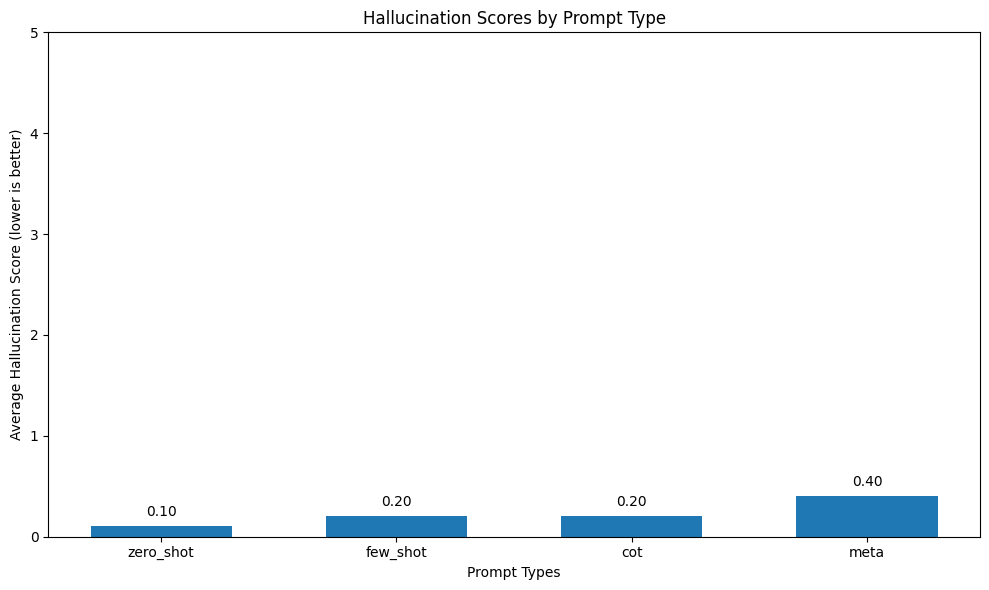

Best performing prompt type: zero_shot


In [12]:
# Cell 9: Visualize prompt comparison
def visualize_prompt_comparison(results):
    """Create visualizations comparing prompt performance"""
    # Extract data for analysis
    prompt_types = list(results["responses"][0]["responses"].keys())
    metrics = {
        "hallucination": {pt: [] for pt in prompt_types}
    }
    
    # Calculate metrics for each query and prompt type
    for query_result in results["responses"]:
        for prompt_type in prompt_types:
            response_data = query_result["responses"][prompt_type]
            
            # Hallucination score (lower is better)
            hallucination_score = response_data["hallucination_score"]
            metrics["hallucination"][prompt_type].append(hallucination_score)
    
    # Calculate averages
    averages = {
        metric: {pt: sum(scores) / len(scores) for pt, scores in prompt_data.items()}
        for metric, prompt_data in metrics.items()
    }
    
    # Create bar chart for hallucination scores
    plt.figure(figsize=(10, 6))
    
    # Plot average hallucination scores (lower is better)
    x = list(range(len(prompt_types)))
    scores = [averages["hallucination"][pt] for pt in prompt_types]
    
    plt.bar(x, scores, width=0.6)
    plt.xlabel('Prompt Types')
    plt.ylabel('Average Hallucination Score (lower is better)')
    plt.title('Hallucination Scores by Prompt Type')
    plt.xticks(x, prompt_types)
    plt.ylim(0, 5)
    
    # Add value labels on top of bars
    for i, v in enumerate(scores):
        plt.text(i, v + 0.1, f"{v:.2f}", ha='center')
    
    plt.tight_layout()
    plt.savefig("evaluation/hallucination_comparison.png")
    plt.show()
    
    # Return the best prompt type (lowest hallucination score)
    best_prompt = min(averages["hallucination"].items(), key=lambda x: x[1])[0]
    return best_prompt

# Visualize prompt comparison
best_prompt = visualize_prompt_comparison(results)
print(f"Best performing prompt type: {best_prompt}")


python
# Cell 10: Clean up and free memory
def cleanup():
    """Clean up resources and free memory"""
    global model, tokenizer, pipe
    
    # Delete model and pipeline
    del pipe
    del model
    del tokenizer
    
    # Clear memory
    clear_memory()
    
    logger.info("Cleanup completed")

# Clean up
cleanup()

In [13]:
def cleanup():
    """Clean up resources and free memory"""
    global model, tokenizer, pipe
    
    # Delete model and pipeline
    del pipe
    del model
    del tokenizer
    
    # Clear memory
    clear_memory()
    
    logger.info("Cleanup completed")

# Clean up
cleanup() 

2025-06-23 20:44:46,838 - INFO - Memory cleared
2025-06-23 20:44:46,839 - INFO - Cleanup completed
